In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Starting Task 2: Quantitative Analysis Preparation")
print("=" * 60)

# Load the dataset
df = pd.read_csv('../data/raw/financial_news_dataset.csv')

print("🔍 FNSPID DATASET ANALYSIS")
print("=" * 40)
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Check for any financial data columns
financial_keywords = ['open', 'high', 'low', 'close', 'volume', 'price', 'return', 'change']
financial_columns = [col for col in df.columns if any(keyword in col.lower() for keyword in financial_keywords)]

if financial_columns:
    print(f"✅ Found financial data columns: {financial_columns}")
else:
    print("📰 Dataset contains news data only - preparing for correlation analysis with external stock data")

✅ Starting Task 2: Quantitative Analysis Preparation
🔍 FNSPID DATASET ANALYSIS
Dataset shape: (1407328, 6)
Columns: ['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock']
📰 Dataset contains news data only - preparing for correlation analysis with external stock data


In [7]:
def prepare_news_data(df):
    """
    Prepare news data for correlation analysis with stock prices
    """
    print("🔄 PREPARING NEWS DATA FOR CORRELATION ANALYSIS")
    print("=" * 50)
    
    # Create a copy to avoid modifying original
    news_df = df.copy()
    
    # Ensure datetime is properly formatted
    if 'datetime' not in news_df.columns:
        print("Converting date column to datetime...")
        news_df['datetime'] = pd.to_datetime(news_df['date'], errors='coerce', utc=True)
    
    # Extract date components for time series analysis
    news_df['date_only'] = news_df['datetime'].dt.date
    
    # Handle NaN values in datetime
    valid_dates_mask = news_df['datetime'].notna()
    news_df.loc[valid_dates_mask, 'year'] = news_df.loc[valid_dates_mask, 'datetime'].dt.year
    news_df.loc[valid_dates_mask, 'month'] = news_df.loc[valid_dates_mask, 'datetime'].dt.month
    news_df.loc[valid_dates_mask, 'day_of_week'] = news_df.loc[valid_dates_mask, 'datetime'].dt.day_name()
    
    # Calculate news metrics
    news_df['headline_length'] = news_df['headline'].str.len()
    news_df['word_count'] = news_df['headline'].str.split().str.len()
    
    # Create news frequency metrics (only for valid dates)
    valid_news_df = news_df[valid_dates_mask].copy()
    daily_news_count = valid_news_df.groupby('date_only').size().reset_index(name='daily_news_count')
    stock_daily_news = valid_news_df.groupby(['date_only', 'stock']).size().reset_index(name='stock_daily_news')
    
    print(f"✅ News data prepared:")
    print(f"   • Total articles: {len(news_df):,}")
    print(f"   • Articles with valid dates: {valid_dates_mask.sum():,} ({valid_dates_mask.sum()/len(news_df)*100:.1f}%)")
    
    if valid_dates_mask.sum() > 0:
        valid_dates = news_df.loc[valid_dates_mask, 'date_only']
        print(f"   • Date range: {valid_dates.min()} to {valid_dates.max()}")
    else:
        print(f"   • Date range: No valid dates available")
    
    print(f"   • Unique stocks: {news_df['stock'].nunique()}")
    print(f"   • Unique publishers: {news_df['publisher'].nunique()}")
    
    return news_df, daily_news_count, stock_daily_news

# Prepare the news data
news_df, daily_news_count, stock_daily_news = prepare_news_data(df)

🔄 PREPARING NEWS DATA FOR CORRELATION ANALYSIS
Converting date column to datetime...
✅ News data prepared:
   • Total articles: 1,407,328
   • Articles with valid dates: 55,987 (4.0%)
   • Date range: 2011-04-28 to 2020-06-11
   • Unique stocks: 6204
   • Unique publishers: 1034


In [8]:
def analyze_stock_coverage(news_df):
    """
    Analyze stock coverage patterns in the news data
    """
    print("📈 STOCK COVERAGE ANALYSIS")
    print("=" * 40)
    
    # Stock coverage statistics
    stock_coverage = news_df['stock'].value_counts()
    
    print("🏆 Top 10 Most Covered Stocks:")
    for i, (stock, count) in enumerate(stock_coverage.head(10).items(), 1):
        print(f"   {i:2d}. {stock}: {count:>6} articles")
    
    # Coverage distribution
    coverage_stats = {
        'Total Stocks': len(stock_coverage),
        'Stocks with 100+ articles': (stock_coverage >= 100).sum(),
        'Stocks with 50+ articles': (stock_coverage >= 50).sum(),
        'Stocks with 10+ articles': (stock_coverage >= 10).sum(),
        'Average articles per stock': stock_coverage.mean(),
        'Median articles per stock': stock_coverage.median()
    }
    
    print("\n📊 Coverage Statistics:")
    for stat, value in coverage_stats.items():
        print(f"   • {stat}: {value}")
    
    return stock_coverage

stock_coverage = analyze_stock_coverage(news_df)

📈 STOCK COVERAGE ANALYSIS
🏆 Top 10 Most Covered Stocks:
    1. MRK:   3333 articles
    2. MS:   3238 articles
    3. NVDA:   3146 articles
    4. MU:   3142 articles
    5. QQQ:   3106 articles
    6. NFLX:   3028 articles
    7. M:   3025 articles
    8. EBAY:   3018 articles
    9. GILD:   2968 articles
   10. VZ:   2966 articles

📊 Coverage Statistics:
   • Total Stocks: 6204
   • Stocks with 100+ articles: 3242
   • Stocks with 50+ articles: 4152
   • Stocks with 10+ articles: 5218
   • Average articles per stock: 226.84203739522889
   • Median articles per stock: 109.0


⏰ NEWS PUBLICATION FREQUENCY ANALYSIS
📅 Daily News Statistics:
   • Average daily articles: 22.4
   • Maximum daily articles: 973
   • Minimum daily articles: 1
   • Total days with news: 2502


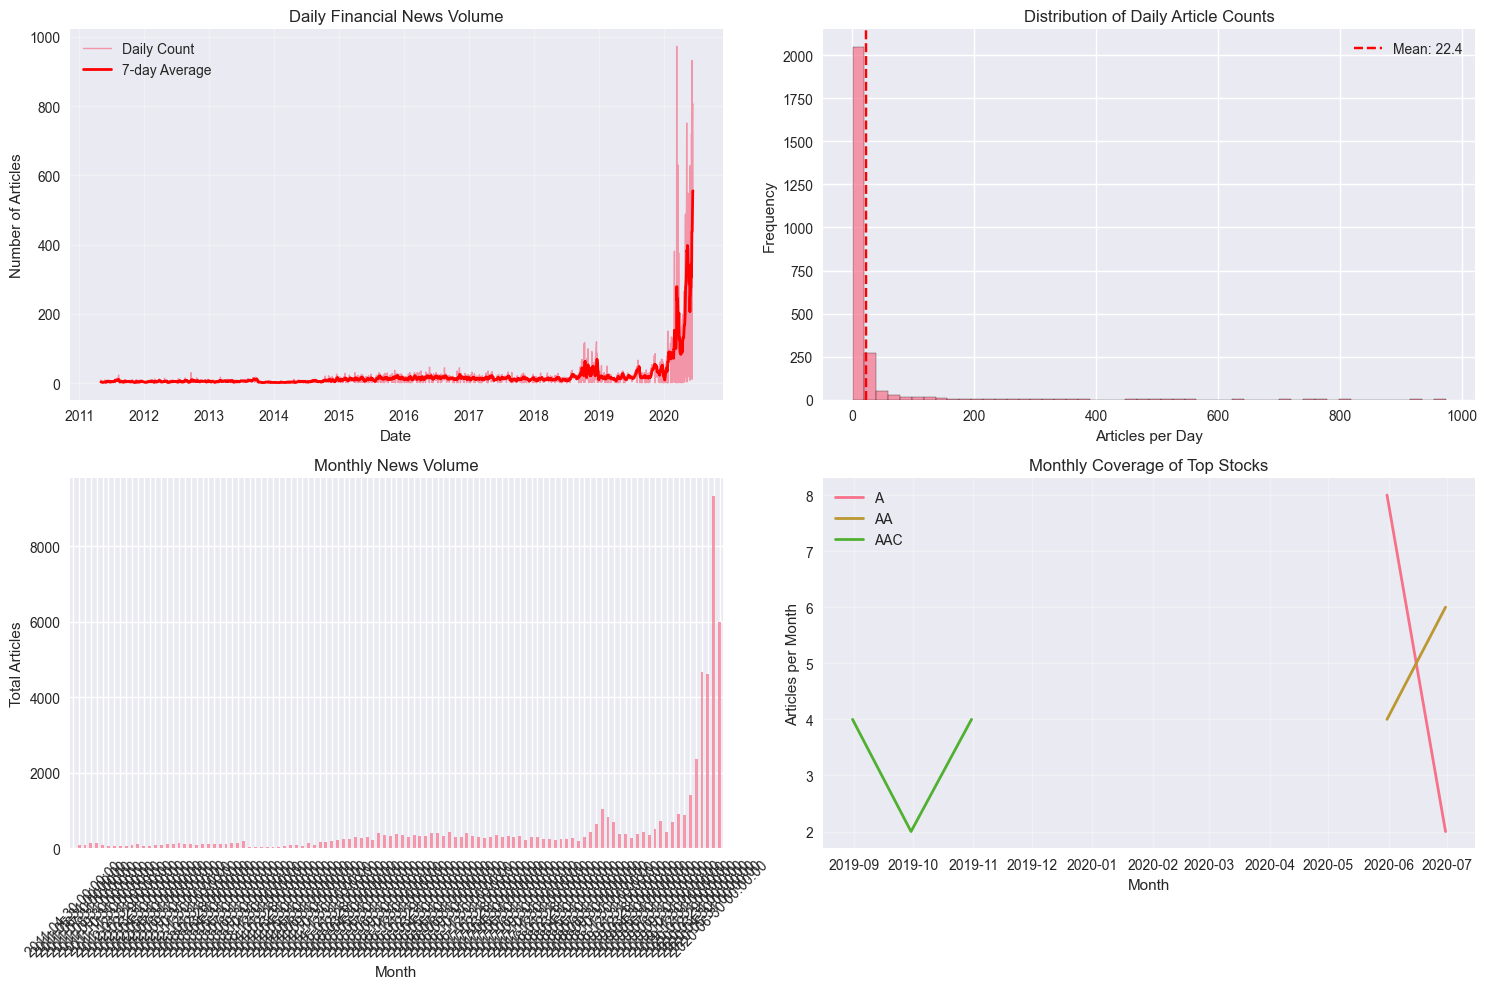

In [9]:
def analyze_news_frequency(daily_news_count, stock_daily_news):
    """
    Analyze news publication frequency patterns
    """
    print("⏰ NEWS PUBLICATION FREQUENCY ANALYSIS")
    print("=" * 50)
    
    if daily_news_count.empty:
        print("❌ No valid daily news data available for analysis")
        return pd.DataFrame()
    
    # Convert to datetime for plotting
    daily_news_count['date'] = pd.to_datetime(daily_news_count['date_only'])
    daily_news_count = daily_news_count.set_index('date').sort_index()
    
    # Calculate rolling statistics (only if we have enough data)
    if len(daily_news_count) >= 7:
        daily_news_count['7_day_avg'] = daily_news_count['daily_news_count'].rolling(window=7).mean()
    if len(daily_news_count) >= 30:
        daily_news_count['30_day_avg'] = daily_news_count['daily_news_count'].rolling(window=30).mean()
    
    print("📅 Daily News Statistics:")
    print(f"   • Average daily articles: {daily_news_count['daily_news_count'].mean():.1f}")
    print(f"   • Maximum daily articles: {daily_news_count['daily_news_count'].max()}")
    print(f"   • Minimum daily articles: {daily_news_count['daily_news_count'].min()}")
    print(f"   • Total days with news: {len(daily_news_count)}")
    
    # Visualization
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Daily news volume
    plt.subplot(2, 2, 1)
    plt.plot(daily_news_count.index, daily_news_count['daily_news_count'], 
             alpha=0.7, label='Daily Count', linewidth=1)
    
    if '7_day_avg' in daily_news_count.columns:
        plt.plot(daily_news_count.index, daily_news_count['7_day_avg'], 
                 label='7-day Average', linewidth=2, color='red')
    
    plt.title('Daily Financial News Volume')
    plt.xlabel('Date')
    plt.ylabel('Number of Articles')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Distribution of daily articles
    plt.subplot(2, 2, 2)
    plt.hist(daily_news_count['daily_news_count'], bins=50, alpha=0.7, edgecolor='black')
    plt.axvline(daily_news_count['daily_news_count'].mean(), color='red', 
                linestyle='--', label=f'Mean: {daily_news_count["daily_news_count"].mean():.1f}')
    plt.title('Distribution of Daily Article Counts')
    plt.xlabel('Articles per Day')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Plot 3: Monthly aggregation
    plt.subplot(2, 2, 3)
    if len(daily_news_count) >= 30:
        monthly_news = daily_news_count['daily_news_count'].resample('M').sum()
        monthly_news.plot(kind='bar', alpha=0.7)
        plt.title('Monthly News Volume')
        plt.xlabel('Month')
        plt.ylabel('Total Articles')
        plt.xticks(rotation=45)
    else:
        plt.text(0.5, 0.5, 'Insufficient data\nfor monthly analysis', 
                 ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Monthly News Volume (Insufficient Data)')
    
    # Plot 4: Top stocks coverage over time (sample)
    plt.subplot(2, 2, 4)
    if not stock_daily_news.empty:
        top_stocks = stock_daily_news.groupby('stock')['stock_daily_news'].sum().nlargest(5).index
        for stock in top_stocks[:3]:  # Plot top 3 for clarity
            stock_data = stock_daily_news[stock_daily_news['stock'] == stock]
            if not stock_data.empty:
                stock_data['date'] = pd.to_datetime(stock_data['date_only'])
                monthly_stock = stock_data.set_index('date')['stock_daily_news'].resample('M').sum()
                plt.plot(monthly_stock.index, monthly_stock.values, label=stock, linewidth=2)
        plt.title('Monthly Coverage of Top Stocks')
        plt.xlabel('Month')
        plt.ylabel('Articles per Month')
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'No stock coverage data', 
                 ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Stock Coverage (No Data)')
    
    plt.tight_layout()
    plt.show()
    
    return daily_news_count

daily_news_analysis = analyze_news_frequency(daily_news_count, stock_daily_news)

In [10]:
def create_technical_framework(stock_coverage):
    """
    Create framework for integrating technical analysis in Task 3
    """
    print("🔧 TECHNICAL ANALYSIS FRAMEWORK")
    print("=" * 40)
    
    # Select top stocks for detailed analysis
    top_stocks = stock_coverage.head(20).index.tolist()
    
    print("🎯 Stocks Selected for Technical Analysis:")
    for i, stock in enumerate(top_stocks[:10], 1):
        print(f"   {i:2d}. {stock}")
    
    # Define technical indicators to calculate (for Task 3)
    technical_indicators = {
        'Price-based': ['SMA_20', 'SMA_50', 'RSI', 'MACD', 'Bollinger_Bands'],
        'Volume-based': ['Volume_SMA', 'Volume_Ratio', 'OBV'],
        'Volatility': ['Daily_Returns', 'Volatility_30d', 'ATR'],
        'Momentum': ['Price_Change', 'Momentum_10d', 'ROC']
    }
    
    print("\n📊 Technical Indicators Framework:")
    for category, indicators in technical_indicators.items():
        print(f"   • {category}: {', '.join(indicators)}")
    
    # Create correlation analysis plan
    correlation_plan = {
        'Sentiment vs Price': "Correlate news sentiment with stock price movements",
        'Volume vs News': "Analyze trading volume around news events", 
        'Volatility Impact': "Measure how news affects stock volatility",
        'Time-based Analysis': "News impact over different time horizons (1h, 1d, 1w)"
    }
    
    print("\n📈 Correlation Analysis Plan:")
    for analysis, description in correlation_plan.items():
        print(f"   • {analysis}: {description}")
    
    return top_stocks, technical_indicators

top_stocks, tech_indicators = create_technical_framework(stock_coverage)

🔧 TECHNICAL ANALYSIS FRAMEWORK
🎯 Stocks Selected for Technical Analysis:
    1. MRK
    2. MS
    3. NVDA
    4. MU
    5. QQQ
    6. NFLX
    7. M
    8. EBAY
    9. GILD
   10. VZ

📊 Technical Indicators Framework:
   • Price-based: SMA_20, SMA_50, RSI, MACD, Bollinger_Bands
   • Volume-based: Volume_SMA, Volume_Ratio, OBV
   • Volatility: Daily_Returns, Volatility_30d, ATR
   • Momentum: Price_Change, Momentum_10d, ROC

📈 Correlation Analysis Plan:
   • Sentiment vs Price: Correlate news sentiment with stock price movements
   • Volume vs News: Analyze trading volume around news events
   • Volatility Impact: Measure how news affects stock volatility
   • Time-based Analysis: News impact over different time horizons (1h, 1d, 1w)


In [16]:
def prepare_for_task_3(news_df, top_stocks, daily_news_count, stock_daily_news):
    """
    Prepare and export data for Task 3 correlation analysis
    """
    print("📤 PREPARING FOR TASK 3: CORRELATION ANALYSIS")
    print("=" * 50)
    
    # Create analysis-ready datasets
    analysis_data = {
        'news_data': news_df[['datetime', 'date_only', 'stock', 'publisher', 'headline', 
                             'headline_length', 'word_count', 'year', 'month', 'day_of_week']],
        'top_stocks': top_stocks,
        'daily_news_frequency': daily_news_count,
        'stock_daily_frequency': stock_daily_news
    }
    
    # Save for Task 3
    import os
    
    
    # Save key datasets
    news_df.to_csv('../data/processed/news_analysis_ready.csv', index=False)
    daily_news_count.to_csv('../data/processed/daily_news_frequency.csv')
    
    print("✅ Data prepared for Task 3:")
    print(f"   • News data shape: {news_df.shape}")
    print(f"   • Top stocks selected: {len(top_stocks)}")
    print(f"   • Daily frequency data: {len(daily_news_count)} days")
    print(f"   • Files saved to data/processed/")
    
    return analysis_data

analysis_data = prepare_for_task_3(news_df, top_stocks, daily_news_count, stock_daily_news)

📤 PREPARING FOR TASK 3: CORRELATION ANALYSIS
✅ Data prepared for Task 3:
   • News data shape: (1407328, 13)
   • Top stocks selected: 20
   • Daily frequency data: 2502 days
   • Files saved to data/processed/
